Data Assignment 2

TF-IDF

Isabel Arvelo

# Introduction

Genre classification plays a crucial role in helping readers discover books that align with their interests. This analysis aims to address this challenge by building a Naive Bayes classifier that utilizes the Term Frequency-Inverse Document Frequency (TF-IDF) technique to classify books as either science fiction or historical fiction based on their plot summaries. 
The TF-IDF approach allows us to represent each plot summary as a vector of numerical features, capturing the importance of individual words in distinguishing between the two genres.Previous work (Fei, Zhang 2019) has shown that a TF-IDF text representation and Support Vector Machine (SVM) classification can effectively analyze movie genres based on text containing movie information. Alkaff et al 2020 found that different classification algorithms using TF-IDF as features have varying performance. By leveraging the power of machine learning and natural language processing, we can automate the genre classification process and provide a reliable tool for readers, librarians, and book recommendation systems to make predictions on new, unseen plot summaries and classify them as either science fiction or historical fiction.

The goal of this paper is to explore the effectiveness of using TF-IDF features and the Naive Bayes classifier for distinguishing between science fiction and historical fiction books based on their plot summaries. This would highlight the importance of words within summaries relative to their frequency across all the summaries. This would allow you to identify which words are uniquely significant to certain categories.

Research Questions:

1. What are the most informative words or phrases in plot summaries that distinguish science fiction from historical fiction books?
2. How effective is the combination of TF-IDF feature representation and different machine learning classification models in accurately classifying books into science fiction or historical fiction genres based on their plot summaries?

# Method

## Corpus 

The corpus for this project is a subset of data from the CMU Book Summary Corpus (Bamman & Smith, 2013), a collection of 16,559 book plot summaries extracted from Wikipedia, along with aligned metadata from Freebase (a massive, collaboratively edited database of cross-linked data with data from users and sources such as Wikipedia), including book author, title, and genre. There are 1,280 books in the corpus, with 640 books classified as science fiction and 640 books classified as historical fiction. The corpus is evenly balanced between the two genres, with each genre containing 50% of the books. The plot summaries are written in English and contain a mix of words, phrases, and sentences that describe the main events, characters, and themes of the book. The summaries have an average length of 3043 (SD = 3289) words for science fiction books and 3098(SD =3340) words for historical fiction books. The corpus contains 286 unique authors for historical fiction books and 347 unique authors for science fiction books. The top 10 most frequent authors account for 29% of historical fiction books and 14% of science fiction books. Given the crowd sourced nature of the data, there may be some inconsistencies in plot summary quality, but overall, the corpus provides a rich and diverse dataset for training and evaluating the genre classification model.

## TF-IDF Features

Term Frequency-Inverse Document Frequency (TF-IDF) is a widely used technique in natural language processing and text mining for quantifying the importance of words within a document. It is calculated as the product of two components: term frequency (TF) and inverse document frequency (IDF). The term frequency (TF) represents the frequency of a word within a particular document, normalized by the total number of words in that document. This captures the prevalence of each word in the given text. The inverse document frequency (IDF), on the other hand, measures the rarity of a term across the entire corpus of documents. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the specific term. This component dampens the effect of common words that appear frequently across multiple documents, and emphasizes the importance of more distinctive and informative terms.

The combination of term frequency and inverse document frequency in the TF-IDF calculation results in a numerical statistic that reflects the relative importance of a word to a document within a larger collection or corpus. This approach is advantageous due to its simplicity, computational efficiency, and effectiveness as a starting point for various text similarity calculations, such as through vector representations and cosine similarity.

## Linguistic Analysis 

spaCy (3.7.4), an industrial grade software library for advanced natural language processing (NLP), was employed to tokenize the plot summaries, removing stop words and other non-informative tokens, such as punctuation marks and numbers. We then used the CountVectorizer class from the scikit-learn library (1.4.1.post1) to convert the tokenized text into a matrix of word counts. to help us explore the vocabulary and linguistic patterns in the data. After this initial count vectorization, we used the TfidfVectorizer from the same library to convert the word counts into TF-IDF features, which were then used as input to the classification model.

## Machine Learning Analysis 

We used the scikit-learn library (1.4.1.post1) in Python to build three different classification models: Naive Bayes, Support Vector Machine (SVM), and Logistic Regression that used the TD-IDF features extracted from the plot summaries as inputs to predict whether a plot summary was for a historical fiction or scientific fiction novel. These models were trained and evaluated using 5-fold cross-validation to assess their performance with different hyperparameters for the models, as well as the TD-IDF vectorizer. The best performing model was selected based on these metrics, further trained on the entire training split, and analyzed to identify the most informative features and patterns that distinguish between the two genres.

# Data Preprocessing

The data pre-processing involved the following steps:

1. Removing rows missing genre labels or 
2. Parse Out Subject Labels 
3. Filter the dataset down to a balanced subset with an equal number of historical fiction and science fiction texts 
4. Assess the plot summary lengths and check for all duplicate records 


In [324]:
#### Importing Libaries ####

# Data Manipulation Libraries
import string
import pandas as pd
import numpy as np
from itertools import chain,cycle

# Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html

# Machine Learning Libraries 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# NLP Libaries 
from spacy.lang.en.stop_words import STOP_WORDS
import spacy

SEED = 59

In [392]:
#### Setting up NLP pipeline #### 

# want to exclude 326 stopwords from the spacy stopword list in addition to two other common words I found across the corpus
STOP_WORDS.add("novel")
STOP_WORDS.add("find")

stop_words = STOP_WORDS

# English tokenizer
nlp = spacy.load('en_core_web_sm', exclude=["parser", "ner"])

def tokenize_docs(doc):
  tokens  =[]

  for tok in doc:
      
      # Remove stop words, punctuations, numbers, and non-alphabetic characters
    if (not tok.is_punct
            and not tok.is_space
            and not tok.like_num
            and tok.is_alpha
            and len(tok.text) > 1
            and not tok.is_currency
            and not tok.is_digit
            and tok not in stop_words
            and tok.is_ascii
            ):
          final_tok = tok.lemma_.lower()
          if final_tok not in stop_words:
              tokens.append(final_tok)
  return tokens
    

In [393]:
#### Reading in Data  ####  

df = pd.read_csv("booksummaries.txt", 
                 sep="\t", 
                 names=["ID", "m number", "book name", "author", "date", "label", "summary"])


In [394]:
# Get the range of years in the dataset
df["date_year"] = pd.to_numeric(df["date"].str.split("-", expand =True )[0])
df["date_year"].describe()

count    10949.000000
mean      1975.924194
std         49.641921
min        398.000000
25%       1966.000000
50%       1991.000000
75%       2003.000000
max       2013.000000
Name: date_year, dtype: float64

In [395]:
# Remove 3718 rows where label is NaN
df = df[df["label"].notnull()]

In [329]:
# Parse Out Subject Labels 
df["new_label"] = df["label"].apply(lambda x: list(eval(x).values()) if type(x) == str else x)

In [330]:
# Find all the unique value in the lists of the new_label column
all_labels = []

for label_list in df["new_label"]:
    for label in label_list:
        all_labels.append(label)

unique_labels = set(all_labels)

# Get value counts out of the unique labels to inform which labels to keep
label_counts = pd.Series(all_labels).value_counts()
label_counts.head(15)

Fiction                   4747
Speculative fiction       4314
Science Fiction           2870
Novel                     2463
Fantasy                   2413
Children's literature     2122
Mystery                   1396
Young adult literature     825
Suspense                   765
Crime Fiction              753
Historical novel           654
Thriller                   568
Horror                     511
Romance novel              435
Historical fiction         388
Name: count, dtype: int64

In [331]:
# Filter dataset down to rows that have Science Fiction OR Historical Fiction as a label
df_filtered = df[df["new_label"].apply(lambda x: "Science Fiction" in x or "Historical novel" in x)]

In [332]:
# Count the minimum number of books in either genre to decide how many of each to include in balanced dataset 
np.min([df_filtered["new_label"].apply(lambda x: "Science Fiction" in x).sum(), df_filtered["new_label"].apply(lambda x: "Historical novel" in x).sum()])


654

In [418]:
# Make a new column category that is 1 if the book is Science Fiction and 0 if it is Historical Fiction 
df_filtered_copy = df_filtered.copy()
df_filtered.loc[:,"category"] = df_filtered_copy["new_label"].apply(lambda x: 1 if "Science Fiction" in x else 0)

In [334]:
# Make df_filtered balanced by taking the same number of Science Fiction and Historical Fiction books
df_filtered_balanced = df_filtered.groupby("category")[['ID', 'm number', 'book name', 'author', 'date', 'label', 'summary',
       'new_label', 'category']].apply(lambda x: x.sample(n=640, random_state=SEED), include_groups = False).droplevel(0)

# Reset the index
df_filtered_balanced.reset_index(drop=True, inplace=True)


In [335]:
# Find the length of the summaries for each genre

science_fiction_df = df_filtered_balanced[df_filtered_balanced["category"] == 1]
historical_fiction_df = df_filtered_balanced[df_filtered_balanced["category"] == 0]

sf_lens =  science_fiction_df["summary"].str.len()
hf_lens =  historical_fiction_df["summary"].str.len()

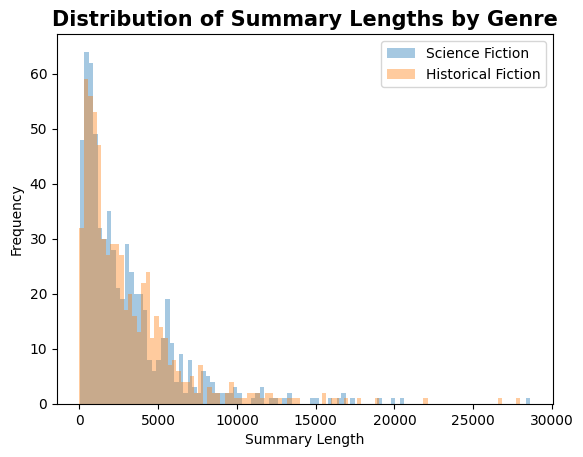

In [336]:
# Make a plot overlaying the distribution of summary length by genre 
plt.hist(sf_lens, bins=100, alpha=0.4, label='Science Fiction')
plt.hist(hf_lens, bins=100, alpha=0.4, label='Historical Fiction')
plt.xlabel("Summary Length")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.title("Distribution of Summary Lengths by Genre", fontsize=15, fontweight='bold')
plt.show()

The distribution of the length of the summaries is similar for both genres.The distribution of lengths is skewed right with the median length falling around 2080, with the middle 50% of lengths falling between about 850 and 4200 words. The longest summary is over 28,000 words, while the shortest is 11 words. 

In [337]:
# Verify that all the book names are unique

if df_filtered_balanced["book name"].duplicated().sum() > 0:
    duplicated_book_name = df_filtered_balanced[df_filtered_balanced["book name"].duplicated()]["book name"].unique()

    # Check number of authors for each book in the duplicated book names
    print(df_filtered_balanced[df_filtered_balanced["book name"].isin(duplicated_book_name)]["author"].value_counts())

author
Walter Scott              1
Patrick O'Brian           1
Alessandro Manzoni        1
C. S. Forester            1
Matthew Tobin Anderson    1
Seanan McGuire            1
Name: count, dtype: int64


All of the books that have the same title are written by differnt authors, which confirms that all of the records in the corpus are unique.

# NLP Analysis

The NLP analysis for this assignment is below. The steps taken include:

1. Term Frequency Vectorization to explore the most frequent words in the plot summaries 
2. TF-IDF Vectorization to calculate the importance of words in distinguishing between science fiction and historical fiction
3. Hyperparameter tuning for the different classification using GridSearchCV


In [338]:
# Pass the plot summary column through the nlp pipeline to get doc objects
docs = list(nlp.pipe(df_filtered_balanced.summary))

### Term Frequency (TF)

In [396]:
# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(tokenizer=tokenize_docs, token_pattern=None, lowercase=False, min_df = 3) 

# Fit the CountVectorizer to the data
X = count_vectorizer.fit_transform(docs)

# Convert it to an array and output a pandas dataframe
bow_df = pd.DataFrame(X.toarray())
bow_df.columns = count_vectorizer.get_feature_names_out() # Get the feature names from the CountVectorizer

In [397]:
len(bow_df.columns)

8991

There are 8,991 unique tokens that appear in at least 3 different summaries across the corpus.

In [398]:
count_vectorizer = CountVectorizer(tokenizer=tokenize_docs, token_pattern=None, lowercase=False) #

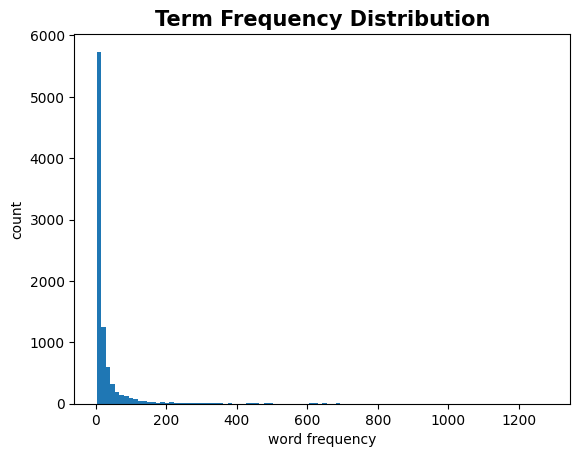

In [399]:
bow_df.sum().plot.hist(bins=100)
plt.xlabel('word frequency')
plt.ylabel('count')
plt.title('Term Frequency Distribution', fontsize=15, fontweight='bold')
plt.show();

The term frequency follows a zipfian distribution, which reflects Zipf's Law, a mathematical power law where the frequency of any word is inversely proportional to its rank in the frequency table (Piantadosi, 2014), demonstrating a consistent pattern across various languages. This distribution is characterized by a few words that show up very often, many words that are also quite common, and a large number of words that are rarely used. 

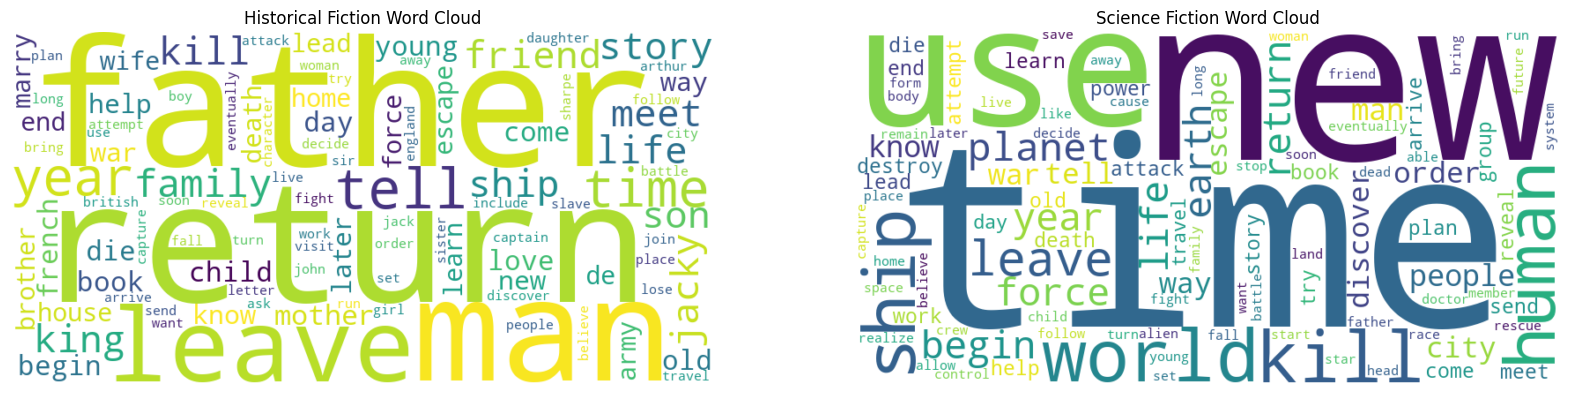

In [400]:
#### Word Clouds for EDA  ####  

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the most common words in historical fiction books
historical_fiction_words = bow_df[df_filtered_balanced["category"] == 0].sum().sort_values(ascending=False)

# Get the most common words in science fiction books
science_fiction_words = bow_df[df_filtered_balanced["category"] == 1].sum().sort_values(ascending=False)

# Create a word cloud for historical fiction
hist_fiction_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(historical_fiction_words)

# Create a word cloud for science fiction
sci_fi_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(science_fiction_words)

# Create subplots
plt.figure(figsize=(20, 10))

# First subplot for historical fiction
plt.subplot(1, 2, 1) # (1 row, 2 columns, 1st subplot)
plt.imshow(hist_fiction_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Historical Fiction Word Cloud")

# Second subplot for science fiction
plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd subplot)
plt.imshow(sci_fi_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Science Fiction Word Cloud")

# Display the plot
plt.show()



A word cloud visualization was created to show the most common words in the plot summaries for both genres. The word cloud highlights the words that appear most frequently in the summaries, with the size of the word indicating its frequency. The word cloud provides a visual representation of the most common words in the plot summaries, allowing us to identify patterns and trends in the language used to describe science fiction and historical fiction books. Common words like "life" are common in both genres. These words will still likely have a low TF-IDF score because a low TF-IDF score because they are ubiquitous across various documents, diminishing their distinguishing power and resulting in a higher document frequency component, which lowers the overall TF-IDF value. There are some words that are more common in one genre than the other. For example, "father" is more common in historical fiction summaries, while "new" is more common in science fiction summaries. This preliminary visualization suggests that there are indeed some words that are more common in one genre than the other, which could be used to classify the summaries.

### TF-IDF Vectorization 

To effectively utilize TF-IDF for our analysis, we first have to transform our collection of text summaries into a TF-IDF feature matrix. Each row of this matrix corresponds to a specific document, while each column aligns with a distinct word from the overall corpus. The entries in this matrix – the TF-IDF scores – are derived by multiplying a word's term frequency (its occurrence within a document) by its inverse document frequency (reflecting its rarity across the corpus). These scores quantitatively reflect the significance of each word in a given document in relation to the entire set of texts.

An important hyperparameter for TF-IDF is setting the minimum document frequency threshold for a word to be included in our working vocabulary. This threshold filters out words appearing in very few documents, which are generally less informative for tasks like classification. If set too low, the threshold leads to an large vocabulary that may include mispellings and other words that may generalize to other texts not in the corpus. Hwoever, a threshold that's too high results in an overly restrictive vocabulary that may omit potentially significant words. Balancing this parameter is key to constructing an effective and efficient TF-IDF model. There is not a strict rule for setting the minimum document frequency threshold, but a common practice in the literature is to set it somewhere around 3, so I will try different models with values close to that. (Jing, Huang, & Shi, 2002; Piantadosi, 2014)

Since the best parameters for the TD-IDF vectorizer may not be the same for each model, we will use GridSearchCV to find the best parameters for the pipeline of the vectorizer and algorithm for each model together, in the next section. 

# Machine Learning Analysis

In order to determine the best model for our classification task, we will evaluate the performance of several different classifiers, including Naive Bayes, Logistic Regression, and Support Vector Machines. The most common algorithms for text classification are Naive Bayes, Logistic Regression, and Support Vector Machines. (CITE HERE)

Naive Bayes is a linear probabilistic classifier based on Bayes' Theorem with the assumption of independence between features. This algorithm operates on the frequency of terms, aligning with TF-IDF's focus on both term frequency and the term's inverse document frequency, providing a balanced measure of word importance. Despite its simplicity, Multinomial Naive Bayes often performs robustly in text classification tasks, leveraging the nuanced representation of text data by TF-IDF (Chingmuankim & Jindal, 2022). An important tuning parameter for this model is the smoothing parameter. It's used to handle the problem of zero probability in the dataset (i.e. manage the issue when a certain category or outcome in the test set has not been observed in the training set). It's a technique called Laplace smoothing, which adds a small value to the probability estimate of each word in the vocabulary. We will use Grid Search Cross Validation to find the optimal value of the smoothing parameter for our Naive Bayes model.

Logistic Regression is a linear model that predicts the probability of a binary outcome. It is a simple and interpretable model that can be used for classification tasks. Logistic Regression is a good choice for text classification tasks because it is computationally efficient and can handle high-dimensional data, such as the TF-IDF feature matrix we have constructed. C is a hyperparameter that controls the regularization strength of the model. Regularization is a technique used to prevent overfitting by penalizing large coefficients in the model and happens by default in this implementation. We will use Grid Search Cross Validation to find the optimal value of C for our Logistic Regression model, and since the default is 1, we will use a range of values around that on the log scale, smaller values of C specify stronger regularization.

Support Vector Machines (SVM) are a class of supervised learning algorithms that can be used for classification tasks. SVMs are particularly well-suited for text classification tasks because they can handle high-dimensional data and can learn complex decision boundaries. SVMs are also known for their ability to generalize well to new, unseen data, making them a popular choice for text classification tasks. In the context of SVM, C is also a regularization parameter, similar to logistic regression, smaller values of C specify stronger regularization.

We will use cross-validation to assess the performance of each model, and we will tune the hyperparameters of the best-performing model to optimize its performance. Cross-validation is the process of splitting the data into training and testing sets multiple times to ensure that the model is robust to different splits of the data. This is particularly important when the dataset is small, as is the case with the book summary corpus. By using cross-validation, we can obtain a more accurate estimate of the model's performance on unseen data. We will use 5-fold cross-validation, which involves splitting the data into 5 equal parts and training the model on 4 parts while testing it on the remaining part. This process is repeated 5 times, with each part serving as the test set once. The final performance metric is the average of the performance metrics obtained in each fold.

In order to determine which classification algorithm to use, we can use Grid Search Cross Validation to grid search over hyperparameters for each algorithm and then compare the performance of the best model (using optimal hyperparameters) for each on our TF-IDF feature matrix. This will allow us to select the best algorithm for our specific text classification task. The models will be evaluated based on their ROC AUC score, which is a common metric for binary classification tasks that measures the trade-off between true positive rate and false positive rate. The ROC AUC score ranges from 0 to 1, with higher values indicating better performance.

Before we begin building our classification model, we need to split our data into training and testing sets. This will allow us to train our model on a subset of the data and evaluate its performance on a completely separate test set that model was not trained or evaulated on during training. 

In [401]:
#### Test/Train Split  ####  

X = df_filtered_balanced['summary'] # the features we want to analyze
ylabels = df_filtered_balanced['category']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state = SEED)

# Pass the summary text in each split through the nlp pipeline
X_train = list(nlp.pipe(X_train))
X_test = list(nlp.pipe(X_test))

In [402]:
#### Define the Pipelines  ####  

# Logistic Regression Pipeline
pipe_lr = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_docs, token_pattern=None, lowercase=False)), # Don't need to lowercase the text because we do it in the tokenizer
    ('classifier', LogisticRegression())
])

# Multinomial Naive Bayes Pipeline (optional, depends on your data)
pipe_nb = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_docs, token_pattern=None, lowercase=False)),
    ('classifier', MultinomialNB())
])

# SVM Pipeline 
pipe_svm = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_docs, token_pattern=None, lowercase=False)),
    ('classifier', SVC())
])

In [403]:
#### Define the parameters for the GridSearchCV ####  

# For Logistic Regression
params_lr = {
    'vectorizer__min_df': [1, 3, 5],
    'classifier__C': [0.1, 1, 10] # Regularization parameter 
}

# Logistic Regression Grid Search
grid_search_lr = GridSearchCV(pipe_lr, param_grid=params_lr, cv=5, verbose=1, n_jobs=-1, scoring = 'roc_auc')


# For Multinomial Naive Bayes 
params_nb = {
    'vectorizer__min_df': [1, 3, 5], 
    'classifier__alpha': [0.1, 1, 10] # Additive (Laplace/Lidstone) smoothing parameter
}
# Multinomial Naive Bayes Grid Search 
grid_search_nb = GridSearchCV(pipe_nb, param_grid=params_nb, cv=5, verbose=1, n_jobs=-1, scoring = 'roc_auc')


# For SVM
params_svm = {
    'vectorizer__min_df': [1, 3, 5],
    'classifier__C': [0.1, 1, 10] # Regularization parameter 
}
# SVM Grid Search
grid_search_svm = GridSearchCV(pipe_svm, param_grid=params_svm, cv=5, verbose=1, n_jobs=-1, scoring = 'roc_auc')


In [404]:
# Fitting logistic regression models 
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/isabelarvelo/Desktop/spring_24/nlp/data-assignment-2/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        token_pattern=None,
                                                        tokenizer=<function tokenize_docs at 0x2c3f52f70>)),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'vectorizer__min_df': [1, 3, 5]},
             scoring='roc_auc', verbose=1)

In [405]:
# Fitting Naive Bayes models 
grid_search_nb.fit(X_train, y_train) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/isabelarvelo/Desktop/spring_24/nlp/data-assignment-2/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        token_pattern=None,
                                                        tokenizer=<function tokenize_docs at 0x2c3f52f70>)),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.1, 1, 10],
                         'vectorizer__min_df': [1, 3, 5]},
             scoring='roc_auc', verbose=1)

In [406]:
# Fitting SVM models
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        token_pattern=None,
                                                        tokenizer=<function tokenize_docs at 0x2c3f52f70>)),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'vectorizer__min_df': [1, 3, 5]},
             scoring='roc_auc', verbose=1)

**Choosing the best model**

In [407]:
# Check best parameters and scores
print("Best LR Params: ", grid_search_lr.best_params_)
print("Best LR Score: ", grid_search_lr.best_score_)

print("Best NB Params: ", grid_search_nb.best_params_) 
print("Best NB Score: ", grid_search_nb.best_score_)   

print("Best SVM Params: ", grid_search_svm.best_params_)
print("Best SVM Score: ", grid_search_svm.best_score_)

Best LR Params:  {'classifier__C': 10, 'vectorizer__min_df': 1}
Best LR Score:  0.9713875899297525
Best NB Params:  {'classifier__alpha': 0.1, 'vectorizer__min_df': 3}
Best NB Score:  0.9739965658473329
Best SVM Params:  {'classifier__C': 1, 'vectorizer__min_df': 3}
Best SVM Score:  0.97048683166432


Although the best model for all three classification algorithms yielded impressive results, the Naive Bayes model outperformed the Logistic Regression and Support Vector Machine models in terms of ROC AUC score, which captures the trade-off between true positive rate and false positive rate. The optimal minimum number of documents for the TD-IDF vectorizer found through cross validation was 3 and the optimal smoothing parameter was 0.1. 

**Fitting the best model**

In [408]:
# Train the best models on the full training set
best_nb_model = grid_search_nb.best_estimator_
best_nb_model.fit(X_train, y_train)


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, min_df=3, token_pattern=None,
                                 tokenizer=<function tokenize_docs at 0x2c3f52f70>)),
                ('classifier', MultinomialNB(alpha=0.1))])

**Model Evaluation**

In [409]:
# Predictions
y_pred_nb = best_nb_model.predict(X_test)

# Classification Report
print(metrics.classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       125
           1       0.96      0.92      0.94       131

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



The model performs very well in distinguishing between Historical Fiction and Science Fiction. The balanced F1-scores for both classes suggest the model is equally good at predicting both classes. The slightly higher precision for Science Fiction (0.96) compared to Historical Fiction (0.92) suggests that when the model predicts an instance to be Science Fiction, it is more likely to be correct than when it predicts an instance to be Historical Fiction. The higher recall for Historical Fiction (0.96) compared to Science Fiction (0.92) indicates the model is slightly better at identifying all relevant instances of Historical Fiction than it is for Science Fiction. The model's high accuracy (0.94) and ROC AUC score (0.97) further support its effectiveness in classifying plot summaries as historical or science fiction. A key note is that the model is only making predictions on historical or science fiction books, so it is not able to predict other genres and this performance may not generalize to a corpus that include plot summaries for books of other genres.

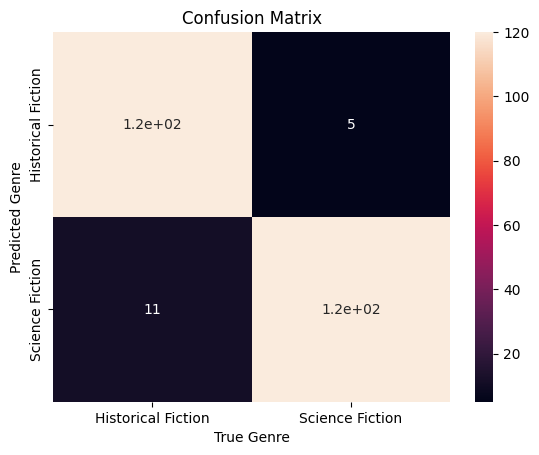

In [410]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('True Genre')
plt.ylabel('Predicted Genre')

# Make the labels represent the actual genre names
plt.xticks(ticks=[0.5, 1.5], labels=['Historical Fiction', 'Science Fiction'])
plt.yticks(ticks=[0.5, 1.5], labels=['Historical Fiction', 'Science Fiction'])

plt.show()


The confusion matrix shows that the model misclassified 11 instances of Historical Fiction as Science Fiction, and 5 instances of Science Fiction as Historical Fiction. This suggests that there are some similarities between the two genres that make them difficult to distinguish based on the plot summaries alone. The model may be misclassifying instances that contain elements of both genres or that are ambiguous in terms of genre, but overall the model is performing very well in distinguishing between the two genres.

**Model Interpretation**

 The log probabilities in a Naive Bayes model can be interpreted as contributing weights to the decision-making process. A higher log probability (less negative, since log probabilities are typically negative) indicates a stronger evidence in favor of a certain class. In contrast, a lower log probability (more negative) indicates weaker evidence for that class.  A log probability isn't the same as a regular probability; it's the logarithm of a probability. This transformation fundamentally changes its interpretation. While a probability expresses a likelihood between 0 and 1, a log probability, especially when using natural logarithms, can range from negative infinity to 0. As a result, a log probability doesn't give you an intuitive sense of likelihood in the way a standard probability does. Log probabilities are best used for comparing relative likelihoods, not for assessing absolute likelihoods. In a Naive Bayes model, the decision rule involves comparing the log probabilities across different classes. The class with the highest log probability is considered the most likely, but this doesn’t translate to an intuitive, absolute probability of the class. The coefficent values' usefulness lies in its comparison to others, not in its standalone meaning.

In [411]:
# Access the TfidfVectorizer from the pipeline
tfidf_vectorizer = best_nb_model.named_steps['vectorizer']

# Get the vocabulary
vocabulary = tfidf_vectorizer.vocabulary_

# Get coefficients from the Multinomial Naive Bayes model
nb_model = best_nb_model.named_steps['classifier']

# Get the feature log probabilities
feature_log_prob = nb_model.feature_log_prob_

# Create a dataframe of the vocabulary and coefficients
vocab_df = pd.DataFrame(tfidf_vectorizer.get_feature_names_out(), columns=['vocabulary'])

# Create a dataframe of the coefficients
coef_df = pd.DataFrame(feature_log_prob, columns=vocab_df['vocabulary']).transpose()

In [413]:
# Identify the Most and Least Indicative Features for Each Class

# Get the most indicative features for each class
most_indicative_features = {}
least_indicative_features = {}

for i, label in enumerate(nb_model.classes_):
    most_indicative_features[label] = coef_df[i].sort_values(ascending=False).head(10)
    least_indicative_features[label] = coef_df[i].sort_values(ascending=True).head(10)

# Make a DataFrame for the most indicative features for each class 
most_indicative_features[0].index.name = 'vocabulary_1'
hf_most_indicative = pd.DataFrame( most_indicative_features[0])
hf_most_indicative  = hf_most_indicative .reset_index()
hf_most_indicative .columns = ['Vocabulary', 'Log Probability']


most_indicative_features[1].index.name = 'vocabulary_2'
sf_most_indicative = pd.DataFrame( most_indicative_features[1])
sf_most_indicative = sf_most_indicative.reset_index()
sf_most_indicative.columns = ['Vocabulary', 'Log Probability']

# Make a DataFrame for the least indicative features for each class 

least_indicative_features[0].index.name = 'vocabulary_1'
hf_least_indicative = pd.DataFrame( least_indicative_features[0])
hf_least_indicative  = hf_least_indicative .reset_index()
hf_least_indicative .columns = ['Vocabulary', 'Log Probability']


least_indicative_features[1].index.name = 'vocabulary_2'
sf_least_indicative = pd.DataFrame( least_indicative_features[1])
sf_least_indicative = sf_least_indicative.reset_index()
sf_least_indicative.columns = ['Vocabulary', 'Log Probability']

In [424]:
from IPython.display import display_html

# Auxiliary function to display dataframes side by side with titles
def display_side_by_side(*args, titles=()):
    html_str = ''
    for df, title in zip(args, titles):
        df_html = df.to_html()
        html_str += f'<div style="display:inline-block;vertical-align:top;margin-right:20px;"><h4>{title}</h4>{df_html}</div>'
    display_html(html_str, raw=True)

In [427]:
print("Most Indicative Features")
display_side_by_side(hf_most_indicative, sf_most_indicative, titles=['Historical Fiction', 'Science Fiction'])  

Most Indicative Features


,Vocabulary,Log Probability
0,father,-5.955921
1,story,-6.064901
2,king,-6.097396
3,family,-6.187459
4,man,-6.191879
5,book,-6.217904
6,sharpe,-6.218826
7,war,-6.254649
8,return,-6.273433
9,love,-6.279056


More negative values indicate lower probabilities, but in this context, the relative value matters more for understanding which words are most characteristic of each category.For the first category, words like "father," "story," "novel," "king," "family," "man," "sharpe," "book," and "war" are the most indicative. The presence of words like "king," "war," and "sharpe" suggests a focus on historical figures, events, or military themes, which are common in historical fiction. The word "sharpe" could be referencing a specific character or series often found in historical fiction literature. Additionally, words like "father," "family," and "man" indicate themes around relationships and personal narratives, which are also typical in historical fiction stories.

In the second category, words such as "planet," "human," "earth," "world," "ship," "new," "use," "time," and "kill" are the most indicative. The frequent occurrence of words like "planet," "ship," and "earth" points to common science fiction themes such as space travel, exploration, and extraterrestrial life. Moreover, words like "human," "world," and "new" could suggest narratives around human experiences in diverse and novel settings, a hallmark of science fiction.


In [428]:
print("Least Indicative Features")
display_side_by_side(hf_least_indicative, sf_least_indicative, titles=['Historical Fiction', 'Science Fiction'])

Least Indicative Features


,Vocabulary,Log Probability
0,tycho,-10.790159
1,geneticist,-10.790159
2,milky,-10.790159
3,suspiciously,-10.790159
4,upgrade,-10.790159
5,warlock,-10.790159
6,suspend,-10.790159
7,migrate,-10.790159
8,automate,-10.790159
9,automatic,-10.790159


Words like "tycho" (a latinization of aGreek name), "trajectory," "geneticist," "milky," and "upgrade" are least indicative of historical fiction novels. This suggests that they are either very rare in the dataset or are equally likely to appear across different genres or categories, thus not providing strong distinguishing features. Many of these words, like "milky,"  or "upgrade," could appear in various contexts, making them less useful for genre classification. The specific nature of these words could also indicate that they come from very niche areas or specific contexts that are not frequent enough in the corpus to be characteristic of a broader genre.

Similarly, words such as "praetorian," "comte," and "prosecutor,"are least indicative of its science fiction novels. It is interesting to see the word "protestant" in this list, as this could represent the lack of religious themes in science fiction novels. On the whole, these *least indicative* words seem to be either very specific (like "comte" which is a French cheese), words that might appear across various genres, or words related to specific historical or cultural references that are not widely represented in the dataset (like "praetorian", which was a unit of the Imperial Roman army). 

In both cases, the fact that these words are least indicative doesn't mean they are unimportant in general, but rather that they do not play a significant role in differentiating between the specfic historical fiction and science fiction categories in the model. This could be due to a variety of reasons, including their rarity, their uniform distribution across genres, or their context-specific nature. 

# Conclusion 

A TF-IDF-based model for classifying books into genres based on their plot summaries has numerous practical applications. One potential applications of this model could be in the development of recommendation systems. Online bookstores, libraries, and reading apps can integrate genre classification model to provide personalized book suggestions to their users. By analyzing the plot summaries of books and identifying their genres, the model can help readers discover new titles that align with their reading preferences. This not only enhances the user experience but also promotes book discoverability, exposing readers to a wider range of books within their favorite genres.Moreover, the model could assist librarians in cataloging and organizing large book collections. Manually categorizing books into genres can be a time-consuming and labor-intensive task. By automating the genre classification process, the model can save librarians significant time and effort. It would enable them to quickly and accurately assign genre labels to books based on their plot summaries, streamlining the cataloging process and making it easier for patrons to locate books of interest. Furthermore, the methodology used to develop this model can be applied to other domains, such as movie and TV show recommendation systems, where plot summaries play a crucial role in determining the genre and target audience. By adapting the model to these contexts, it can provide valuable insights and recommendations to viewers, enhancing their entertainment experience. These preliminary results indicate that even a simple, low-resource, and easy-to-implement model that uses TF-IDF features can effectively classify books into genres based on their plot summaries. 

# Limitations

While the TF-IDF approach offers several advantages for text classification tasks, it is important to acknowledge its limitations in the context of this analysis. One notable limitation is that TF-IDF treats each word as an independent unit and disregards the order in which words appear. Consequently, compound nouns such as "mother-in-law," "merry-go-round," and "air conditioner" are not considered as single semantic units, potentially losing some contextual information. Another limitation of this analysis is the absence of a specified maximum document frequency (max_df) value in the vectorizer. The max_df parameter determines the upper limit for the proportion of documents in which a term can appear to be included in the vocabulary. Not setting this value may result in the inclusion of overly common words that do not contribute significantly to the classification task.

Furthermore, the corpus used in this analysis was not subjected to a comprehensive spell-checking process. Although the minimum document frequency in the TD-IDF vectorizer would remove misspelled words unless they were misspelled in the same way in three different texts and likely appear infrequently compared to their correctly spelled counterparts, the presence of such errors may still introduce some noise into the analysis. It is also worth noting that the hyperparameter tuning process in this analysis involved a grid search with a limited set of values for each hyperparameter. While this approach helped in finding a reasonably good combination of hyperparameters, it is possible that better values exist beyond the tested range. Expanding the search space and conducting a more extensive hyperparameter optimization could potentially improve the model's performance.

Lastly, the scope of this analysis is limited to the classification of books as either science fiction or historical fiction based on their plot summaries. While this binary classification serves as a good starting point for demonstrating the effectiveness of the TF-IDF approach, it may not be directly applicable to real-world scenarios where a more granular or diverse set of genres is required. Extending the analysis to include additional genres and exploring multi-class classification techniques could enhance the practical utility of the model. Despite these limitations, the TF-IDF analysis presented here provides valuable insights into the application of machine learning techniques for text classification tasks. By acknowledging and addressing these limitations, future research can build upon this foundation to develop more robust and comprehensive models for genre classification and other text analysis applications.

# Future Directions

Future research for this TF-IDF-based genre classification analysis should expand the scope to multi-class classification, incorporating a wider range of genres or subcategories of fiction and exploring their relationships and overlaps. Experimenting with other advanced NLP techniques like transformer models that better capture the relationships between words, could improve performance on a task this type of classification task and also help make the model more generalizable to out of vocabulary words, those words not in the original corpus. Additionally, extending the analysis to cross-domain and cross-lingual settings, such as classifying genres across different forms of storytelling or in various languages, would broaden the applicability and the approach.

# References

Bamman, D., & Smith, N. A. (2013). New alignment methods for discriminative book summarization. arXiv preprint arXiv:1305.1319.

Chingmuankim, & Jindal, R. (2022). Classification and Analysis of Textual Data Using Naive Bayes with TF-IDF. In 2022 4th International Conference on Electrical, Control and 
    Instrumentation Engineering (ICECIE) (pp. 1-9). Kuala Lumpur, Malaysia. https://doi.org/10.1109/ICECIE55199.2022.10000309

Jing, L.-P., Huang, H.-K., & Shi, H.-B. (2002). Improved feature selection approach TFIDF in text mining. In Proceedings of the International Conference on Machine Learning and Cybernetics (Vol. 2, pp. 944-946). Beijing, China. https://doi.org/10.1109/ICMLC.2002.1174522

Milios, E., Zhang, Y., He, B., & Dong, L. (2003). Automatic term extraction and document similarity in special text corpora. In Proceedings of the 6th Conference of the Pacific Association for Computational Linguistics (PACLing’03) (pp. 275-284). Halifax, Nova Scotia, Canada.

Piantadosi, S. T. (2014). Zipf's word frequency law in natural language: A critical review and future directions. Psychonomic Bulletin & Review, 21(5), 1112–1130. https://doi.org/10.3758/s13423-014-0585-6

